To get the parallel stuff to work, you need to go into the terminal in whichever environment you are in and type 'ipcluster start --n=60' where n is the number of engines. Need to have ipyparallel and ipcluster installed. 

In [1]:
import pandas as pd
import hddm
import scipy as sp
import seaborn as sns
import os
import warnings 
warnings.filterwarnings('ignore')# I'm sick of all the red.
os.environ['R_HOME'] = '/Users/mlm2/anaconda/envs/pythonthreefive/lib/R' # couldn't find R in this environment for some reason
% matplotlib inline 
% load_ext rpy2.ipython
%R library(lsmeans)
%R library(afex)
%R library(ppcor)

/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


array(['ppcor', 'MASS', 'afex', 'reshape2', 'lme4', 'Matrix', 'lsmeans',
       'estimability', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='|S12')

In [2]:
import ipyparallel as ipp
from ipyparallel import Client

c = ipp.Client(timeout=100)
view = c.load_balanced_view()

In [5]:
%%px --local
# if you don't do this then the 60 nodes can't find accumodel
import accumodel
#accumodel.set_estimator(accumodel.estimators.OptimizeEstimator(accumodel.models.WaldAntiStopFixedThresh))
accumodel.set_estimator(accumodel.estimators.OptimizeEstimator(accumodel.models.WaldAntiStop))

# Flanker Depressed

In [11]:
clin_data = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_Clin_s1_Mar-16-1002AM-2017.csv')
use = clin_data[clin_data.flanker_qc == 1] # only use these people
subs_to_use = use.ProjectSpecificID.unique()

In [12]:
data = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/Processed/EMBARC_Flk_DDM_Clin_s1_Mar-16-1002AM-2017.csv')

In [13]:
data.groupby('group').ProjectSpecificID.nunique()

group
CTL     40
MDD    292
Name: ProjectSpecificID, dtype: int64

In [14]:
# remove the MDDs included in the 2015 paper

dillon_wiecki_sample = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/depressed_flanker_tw.csv')
data_2017 = data.loc[~data.ProjectSpecificID.isin(dillon_wiecki_sample.subj_idx.unique())]
data_2017 = data_2017.append(data[data.group == 'CTL'])

In [15]:
# now how many peeps do we have?
data_2017.groupby('group').ProjectSpecificID.nunique()

group
CTL     40
MDD    194
Name: ProjectSpecificID, dtype: int64

In [19]:
# put data in the correct format for DDM
data_2017['rt'] /= 1000.
data_2017['response'] = data_2017.accuracy
data_2017['subj_idx'] = data_2017.ProjectSpecificID
data_2017['conf'] = False
data_2017['cond'] = 'incong'
data_2017.loc[data_2017.stimulus == 'CON', 'cond'] = 'cong'
data_2017.loc[data_2017.cond == 'incong', 'conf'] = True

#data = data[data.outlier == 0] # accumodel has it built in to take out the outliers

data_2017 = hddm.utils.flip_errors(data_2017)
data_2017.ix[data_2017.conf, 'rt'] *= -1

In [20]:
# remove the people who should be excluded based on qc fails
data_2017 = data_2017.loc[data_2017.ProjectSpecificID.isin(subs_to_use)] 

# now how many are we left with?
data_2017.groupby('group').ProjectSpecificID.nunique()

group
CTL     37
MDD    174
Name: ProjectSpecificID, dtype: int64

In [21]:
data_2017.head()

,ProjectSpecificID,site,subject,session,group,block,trial,stimulus,response,accuracy,rt,feedback,ln_rt,outlier,rab_lam,gratton,subj_idx,conf,cond
9800,CU0049,CU,49,1,MDD,1,1,INC,1.0,1.0,-0.483,Blank,6.180017,0,0,0,CU0049,True,incong
9801,CU0049,CU,49,1,MDD,1,2,CON,1.0,1.0,0.300,Blank,5.703782,0,2,0,CU0049,False,cong
9802,CU0049,CU,49,1,MDD,1,3,INC,1.0,1.0,-0.495,Blank,6.204558,0,0,1,CU0049,True,incong
9803,CU0049,CU,49,1,MDD,1,4,CON,1.0,1.0,0.320,Blank,5.768321,0,2,0,CU0049,False,cong
9804,CU0049,CU,49,1,MDD,1,5,INC,1.0,1.0,-0.449,Blank,6.107023,0,0,1,CU0049,True,incong


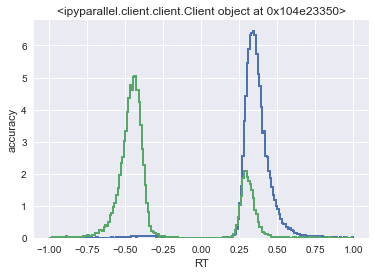

In [22]:
import seaborn as sns
% matplotlib inline 
ax = sns.plt.subplot(1, 1, 1, xlabel='RT', ylabel='accuracy', title=c)
data_2017.ix[data_2017.cond == 'cong', 'rt'].hist(bins=200, histtype='step', range=(-1, 1), normed=True, lw=2, ax=ax);
(data_2017.ix[data_2017.cond == 'incong', 'rt']).hist(bins=200, histtype='step', range=(-1, 1), normed=True, lw=2, ax=ax);

In [ ]:
# Gets parameters for all subjects and puts in a csv

res_dep = view.map_sync(lambda x: accumodel.models.estimate_subj(x), 
                        data_2017.groupby('subj_idx'))
res_dep_df = pd.concat([pd.DataFrame(r).T for r in res_dep])
res_dep_df.to_csv('fits_flanker_just_new_2017.csv', index=True)

In [5]:
def get_param_means(data):
    '''Given the parameter csv, returns group means w/ ttests in a more legible format'''
    list_of_params = ['t', 'v_pro', 'v_stop', 'v_anti', 't_anti', 'a']
    d = {}
    for param in list_of_params:
        results = sp.stats.ttest_ind(data[(data.feasibility == 'MDD')][param],
                data[(data.feasibility == 'CTL')][param])
        means = data.groupby('feasibility')[param].mean()
        p = {}
        p['statistic'] = results[0]
        p['pvalue'] = results[1]
        p['MDD_mean'] = means[1]
        p['CTL_mean'] = means[0]
        d[param] = p
    df = pd.DataFrame.from_dict(d, orient='index')
    return df

In [7]:
# cleaning and merging with groups
just_2017 = pd.read_csv('fits_flanker_just_new_2017.csv') # read in the full parameter file

just_2017.rename(columns={'Unnamed: 0': 'ProjectSpecificID'}, inplace=True)
groups = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/groups.csv') # merge with the clinical data
just_2017 = just_2017.merge(groups, on='ProjectSpecificID')
just_2017['feasibility'].replace(to_replace = 1.0,value = 'MDD', inplace = True) 
just_2017['feasibility'].replace(to_replace = 3.0,value = 'MDD', inplace = True) 
just_2017['feasibility'].replace(to_replace = 5.0,value = 'MDD', inplace = True) 
just_2017['feasibility'].replace(to_replace = 4.0,value = 'CTL', inplace = True) 
just_2017.head() # checking that it looks okay

,ProjectSpecificID,t,a,v_pro,v_stop,v_anti,t_anti,sample,feasibility,trainingset,...,hamd_28,hamd_29,hamd_30,hamd_31,hamd_32,hamd_33,hamd_34,hamd_35,hamd_36,hamd_score_24
0,CU0009,0.243810,0.830434,5.513486,8.782450,13.633526,0.158691,2.0,CTL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CU0013,0.202924,1.198627,8.063158,10.480167,9.406476,0.135845,2.0,CTL,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
2,CU0018,0.200259,1.065285,7.587852,11.839664,13.889670,0.165924,2.0,CTL,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CU0019,0.216602,1.159251,8.023814,9.065725,12.875585,0.156281,2.0,CTL,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CU0020,0.248653,1.024131,6.568923,9.108332,8.583525,0.110399,2.0,CTL,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# double check that it looks okay
just_2017.groupby('feasibility').ProjectSpecificID.count()

feasibility
CTL     37
MDD    174
Name: ProjectSpecificID, dtype: int64

In [9]:
# Nothing significant. The control means here are very close to the ones in the paper, which is good. 
get_param_means(just_2017)

,CTL_mean,MDD_mean,pvalue,statistic
a,1.060702,1.121040,0.424685,0.799885
t,0.211846,0.204589,0.398523,-0.845996
t_anti,0.129620,0.139484,0.070124,1.820426
v_anti,10.228221,10.019276,0.690170,-0.399177
v_pro,7.011262,6.651739,0.197713,-1.292206
v_stop,9.793378,9.756365,0.923516,-0.096121


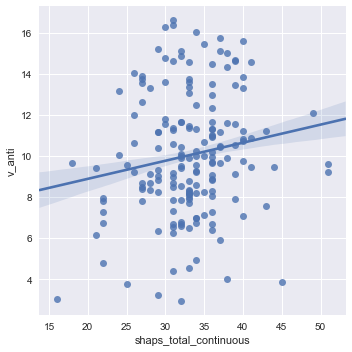

In [10]:
# Does the correlation w/ shaps + v_anti found in the first paper look generally the same?
# NO, this is the opposite of what we see in the 2015 paper

executive_shaps = sns.lmplot(y = 'v_anti', x = 'shaps_total_continuous', data = just_2017[just_2017['feasibility'] == 'MDD'], ci=68)

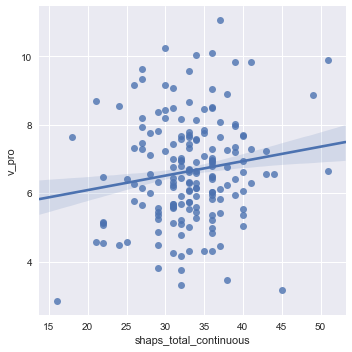

In [11]:
# What about v_pro?
# No, again it's kind of the opposite

prepotent_shaps = sns.lmplot(y = 'v_pro', x = 'shaps_total_continuous', data = just_2017[just_2017['feasibility'] == 'MDD'], ci=68)

## Below doesn't matter, keep for reference

In [8]:
res_dep = view.map_sync(lambda x: accumodel.models.estimate_subj(x, depends_on={'a': 'conf'}), 
                         data.groupby('ProjectSpecificID'))
#res_dep = view.map_sync(lambda x: accumodel.models.estimate_subj(x), 
#                        data.groupby('subj_idx'))
res_dep_df = pd.concat([pd.DataFrame(r).T for r in res_dep])
#res_dep_df = res_dep_df.join(data_dep[['subj_idx', 'session']].groupby(['subj_idx', 'session']).first())
res_dep_df.to_csv('fits_flanker_attempt2.csv', index=True)

Did it work?

In [ ]:
# cleaning and merging with groups
attempt2 = pd.read_csv('fits_flanker_attempt2.csv')
attempt2.rename(columns={'Unnamed: 0': 'ProjectSpecificID'}, inplace=True)
groups = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/groups.csv') # merge with the clinical data
attempt2 = attempt2.merge(groups, on='ProjectSpecificID')
attempt2['feasibility'].replace(to_replace = 1.0,value = 'MDD', inplace = True) 
attempt2['feasibility'].replace(to_replace = 3.0,value = 'MDD', inplace = True) 
attempt2['feasibility'].replace(to_replace = 5.0,value = 'MDD', inplace = True) 
attempt2['feasibility'].replace(to_replace = 4.0,value = 'CTL', inplace = True) 
attempt2.head() # checking that it looks okay

In [ ]:
# double check that it looks okay
attempt2.groupby('feasibility').ProjectSpecificID.count()

In [ ]:
get_param_means(attempt2)

In [9]:
# this goes through each subject in the csv and creates a new csv with the parameters for each of the subjects
for sub in data.ProjectSpecificID.unique():
    sub_data = data.loc[data.ProjectSpecificID == sub]
    res_dep = view.map_sync(lambda x: accumodel.models.estimate_subj(x),
                            sub_data.groupby('subj_idx'))
    res_dep_df = pd.concat([pd.DataFrame(r).T for r in res_dep])
    res_dep_df.to_csv('fits_flanker_' + sub + '.csv', index=True)

In [2]:
# go through all of these individual csvs and make one large df

file_list = !ls TW_components/*csv
tw_df = pd.DataFrame()
for file in file_list:
    tw_df = tw_df.append(pd.read_csv(file))
tw_df.rename(columns={'Unnamed: 0': 'ProjectSpecificID'}, inplace=True)

In [3]:
tw_df.head()

,ProjectSpecificID,t,a,v_pro,v_stop,v_anti,t_anti
0,CU0009,0.243810,0.830434,5.513486,8.782450,13.633526,0.158691
0,CU0011,0.240681,1.410445,7.384086,11.147636,7.677219,0.085399
0,CU0013,0.202924,1.198627,8.063158,10.480167,9.406476,0.135845
0,CU0014,0.254951,0.475997,4.209409,5.397583,5.978123,0.135637
0,CU0016,0.237211,1.357512,6.812568,10.929441,7.290664,0.106280


In [4]:
# merge with the clinical data
clin_df = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/groups.csv')
tw_merged = tw_df.merge(clin_df, on='ProjectSpecificID')

/Users/mlm2/anaconda/envs/pythontwo/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,104,109,113,117,118,119,122,123,127,133,134,135,136,138,141,142,219,221,227,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,250,251,252,253,258,260,262,264,266,268,276,280,283,285,287,290,293,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,336,338,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,392,396,408,410,411,417,418,419,421,422,423,460,462,464,466,468,470,472,474,476,478,480,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,590,800,801,812,813,814,823,861) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
tw_merged.head()

,ProjectSpecificID,t,a,v_pro,v_stop,v_anti,t_anti,sample,feasibility,trainingset,...,hamd_28,hamd_29,hamd_30,hamd_31,hamd_32,hamd_33,hamd_34,hamd_35,hamd_36,hamd_score_24
0,CU0009,0.243810,0.830434,5.513486,8.782450,13.633526,0.158691,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CU0011,0.240681,1.410445,7.384086,11.147636,7.677219,0.085399,1.0,3.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0,12.0
2,CU0013,0.202924,1.198627,8.063158,10.480167,9.406476,0.135845,2.0,4.0,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
3,CU0014,0.254951,0.475997,4.209409,5.397583,5.978123,0.135637,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,21.0
4,CU0016,0.237211,1.357512,6.812568,10.929441,7.290664,0.106280,1.0,3.0,1.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,23.0,34.0


In [13]:
old_ppl = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/depressed_flanker_tw.csv')
old_ppl.head()

,Unnamed: 0,subj_idx,site,subject,session,group,block,trial,stimulus,response,accuracy,rt,feedback,response_side,cond
0,0,CU0009,CU,9,1,0,1,1,INC,1.0,1.0,0.541,Blank,right,incong
1,1,CU0009,CU,9,1,0,1,2,CON,1.0,1.0,0.502,Blank,left,cong
2,2,CU0009,CU,9,1,0,1,3,INC,0.0,0.0,0.379,Blank,right,incong
3,3,CU0009,CU,9,1,0,1,4,CON,1.0,1.0,0.379,Blank,right,cong
4,4,CU0009,CU,9,1,0,1,5,INC,1.0,1.0,0.491,Blank,left,incong


In [7]:
tw_merged['feasibility'].replace(to_replace = 1.0,value = 'MDD', inplace = True) 
tw_merged['feasibility'].replace(to_replace = 3.0,value = 'MDD', inplace = True) 
tw_merged['feasibility'].replace(to_replace = 5.0,value = 'MDD', inplace = True) 
tw_merged['feasibility'].replace(to_replace = 4.0,value = 'CTL', inplace = True) 

Before looking at the results with everyone, I want to look at just the people that were included in the 2015 paper, to make sure the parameters are the same. 

In [39]:
# get the subject IDs for the people that were included in the first paper from the csv that tw sent
data_tw_peeps = tw_merged[tw_merged.ProjectSpecificID.isin(old_ppl.subj_idx.unique())]

# Do we have 37 controls and 92 MDDs as reported in the paper?
# YES
data_tw_peeps.groupby('feasibility').ProjectSpecificID.nunique()

feasibility
CTL    37
MDD    92
Name: ProjectSpecificID, dtype: int64

In [40]:
list_of_params = ['t', 'v_pro', 'v_stop', 'v_anti', 't_anti', 'a']
d = {}
for param in list_of_params:
    results = sp.stats.ttest_ind(data_tw_peeps[(data_tw_peeps.feasibility == 'MDD')][param],
            data_tw_peeps[(data_tw_peeps.feasibility == 'CTL')][param])
    means = data_tw_peeps.groupby('feasibility')[param].mean()
    p = {}
    p['statistic'] = results[0]
    p['pvalue'] = results[1]
    p['MDD_mean'] = means[1]
    p['CTL_mean'] = means[0]
    d[param] = p
df = pd.DataFrame.from_dict(d, orient='index')
df

,CTL_mean,MDD_mean,pvalue,statistic
a,1.028934,1.160762,0.097857,1.667611
t,0.213950,0.205497,0.415732,-0.816520
t_anti,0.128966,0.138768,0.141640,1.478911
v_anti,10.148298,9.322486,0.106415,-1.626062
v_pro,6.984221,6.414638,0.022839,-2.304145
v_stop,9.760866,9.685562,0.850732,-0.188569


In [ ]:
def get_param_means(data):
    list_of_params = ['t', 'v_pro', 'v_stop', 'v_anti', 't_anti', 'a']
    d = {}
    for param in list_of_params:
        results = sp.stats.ttest_ind(data[(data.feasibility == 'MDD')][param],
                data[(data.feasibility == 'CTL')][param])
        means = data.groupby('feasibility')[param].mean()
        p = {}
        p['statistic'] = results[0]
        p['pvalue'] = results[1]
        p['MDD_mean'] = means[1]
        p['CTL_mean'] = means[0]
        d[param] = p
    df = pd.DataFrame.from_dict(d, orient='index')
    return df

The above df is slightly different from the table 1 in the 2015 paper. The v_pro difference is still significant here, but there's no v_anti group difference. There aren't any huge differences between the means here and the means in the paper, but they aren't exactly the same and I'm not really sure why. At first I thought it was because we included the outlier trials, but then I redid it removing those (see TW_components_new folder) and that didn't fix the problem. Accumodels removes the outliers on its own, so they shouldn't be removed beforehand anyway.  
  
What about the correlations that were found in the first paper?

In [35]:
tw_merged[tw_merged['shaps_total_continuous'] > 45]

,ProjectSpecificID,t,a,v_pro,v_stop,v_anti,t_anti,sample,feasibility,trainingset,...,hamd_28,hamd_29,hamd_30,hamd_31,hamd_32,hamd_33,hamd_34,hamd_35,hamd_36,hamd_score_24
129,MG0228,0.169010,1.317666,8.681056,9.189137,11.079160,0.103579,1.0,1.0,0.0,...,0.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,27.0,40.0
182,TX0090,0.139077,1.436811,4.757651,8.164631,5.775166,0.147586,1.0,3.0,1.0,...,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,21.0,30.0
242,UM0008,0.000100,2.961426,6.312529,7.540382,5.773251,0.000100,1.0,3.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0,21.0
257,UM0033,0.210042,1.196539,5.287062,10.250365,6.116461,0.094559,1.0,3.0,1.0,...,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,23.0,33.0
273,UM0065,0.199337,1.130418,9.950146,14.354643,10.344117,0.097524,1.0,5.0,1.0,...,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,24.0,32.0
286,UM0092,0.175546,1.116450,6.780294,9.417060,9.422445,0.146869,1.0,5.0,0.0,...,0.0,4.0,0.0,1.0,2.0,1.0,0.0,0.0,28.0,37.0


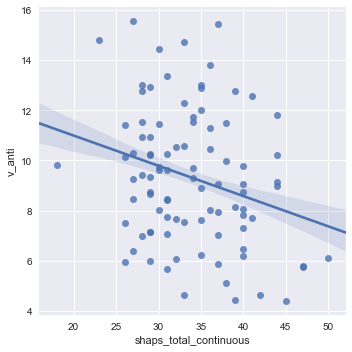

In [41]:
# Does the correlation w/ shaps + v_anti found in the first paper look generally the same?
# Yes, though note that the v_anti scores are not exactly the same. That low shaps is TX0096, who had a v_anti
# of 8 in the paper

executive_shaps = sns.lmplot(y = 'v_anti', x = 'shaps_total_continuous', data = data_tw_peeps[data_tw_peeps['feasibility'] == 'MDD'], ci=68)

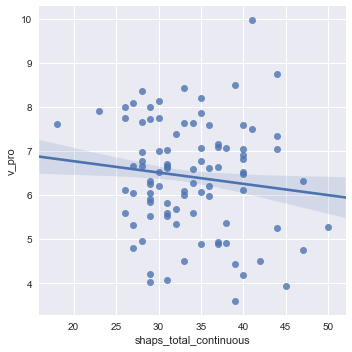

In [42]:
# What about the lack of correlation with v_pro?
# Yes, generally, except for that one really high point, which is UM0027. Nothing looks particularly weird about their data.

prepotent_shaps = sns.lmplot(y = 'v_pro', x = 'shaps_total_continuous', data = data_tw_peeps[data_tw_peeps['feasibility'] == 'MDD'], ci=68)

Is this because our data is different from the first point of analysis?

In [21]:
ours_to_compare = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/to_compare/ours_to_compare.csv')
tw_to_compare = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/Flanker/to_compare/tw_to_compare.csv')

In [22]:
ours_to_compare = ours_to_compare[ours_to_compare.ProjectSpecificID.isin(old_ppl.subj_idx.unique())]

In [23]:
ours_to_compare.head()

,ProjectSpecificID,site,subject,session,group,block,trial,stimulus,response,accuracy,rt,feedback
0,CU0009,CU,9,1,CTL,1,1,INC,1.0,1.0,0.541,Blank
1,CU0009,CU,9,1,CTL,1,2,CON,1.0,1.0,0.502,Blank
2,CU0009,CU,9,1,CTL,1,3,INC,0.0,0.0,0.379,Blank
3,CU0009,CU,9,1,CTL,1,4,CON,1.0,1.0,0.379,Blank
4,CU0009,CU,9,1,CTL,1,5,INC,1.0,1.0,0.491,Blank


In [24]:
tw_to_compare.head()

,ProjectSpecificID,site,subject,session,group,block,trial,stimulus,response,accuracy,rt,feedback
0,CU0009,CU,9,1,CTL,1,1,INC,1.0,1.0,0.541,Blank
1,CU0009,CU,9,1,CTL,1,2,CON,1.0,1.0,0.502,Blank
2,CU0009,CU,9,1,CTL,1,3,INC,0.0,0.0,0.379,Blank
3,CU0009,CU,9,1,CTL,1,4,CON,1.0,1.0,0.379,Blank
4,CU0009,CU,9,1,CTL,1,5,INC,1.0,1.0,0.491,Blank


In [25]:
tw_to_compare['group'].replace(to_replace = '1',value = 'MDD', inplace = True) 
tw_to_compare['group'].replace(to_replace = '0',value = 'CTL', inplace = True) 

In [26]:
# Returns whether or not the two dataframes are the same. It was returning false before b/c the groups are were named 
# differently in the two files (0/1 vs CTL/MDD), and one file had an index. Now that that's removed, it's saying that 
# the two dfs are the same. Also confirmed with sdiff. 
ours_to_compare.equals(tw_to_compare)

True

Even though we'll have to redo once we figure out why the parameters are off, lets look at the parameters with all of the subjects.

In [8]:
tw_merged.groupby('feasibility').ProjectSpecificID.nunique()

feasibility
CTL     37
MDD    266
Name: ProjectSpecificID, dtype: int64

In [9]:
list_of_params = ['t', 'v_pro', 'v_stop', 'v_anti', 't_anti', 'a']
d = {}
for param in list_of_params:
    results = sp.stats.ttest_ind(tw_merged[(tw_merged.feasibility == 'MDD')][param],
            tw_merged[(tw_merged.feasibility == 'CTL')][param])
    means = tw_merged.groupby('feasibility')[param].mean()
    p = {}
    p['statistic'] = results[0]
    p['pvalue'] = results[1]
    p['MDD_mean'] = means[1]
    p['CTL_mean'] = means[0]
    d[param] = p
df = pd.DataFrame.from_dict(d, orient='index')
df

,CTL_mean,MDD_mean,pvalue,statistic
a,1.028934,1.142742,0.091527,1.692806
t,0.213950,0.204295,0.253294,-1.144577
t_anti,0.128966,0.139217,0.067958,1.831875
v_anti,10.148298,9.839170,0.532731,-0.624563
v_pro,6.984221,6.634299,0.155520,-1.423868
v_stop,9.760866,9.769030,0.982231,0.022290


What about the correlations?

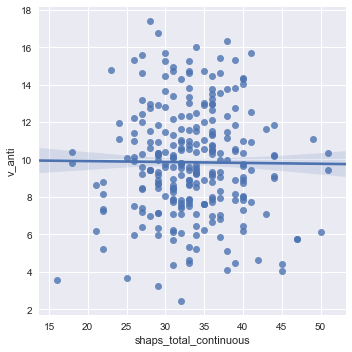

In [10]:
# Does the v_anti correlation remain? 
# No

executive_shaps = sns.lmplot(y = 'v_anti', x = 'shaps_total_continuous', data = tw_merged[tw_merged['feasibility'] == 'MDD'], ci=68)

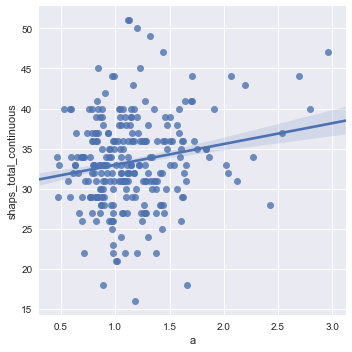

In [12]:
# Does the v_anti correlation remain? 
# No

executive_shaps = sns.lmplot(y = 'shaps_total_continuous', x = 'a', data = tw_merged[tw_merged['feasibility'] == 'MDD'], ci=68)

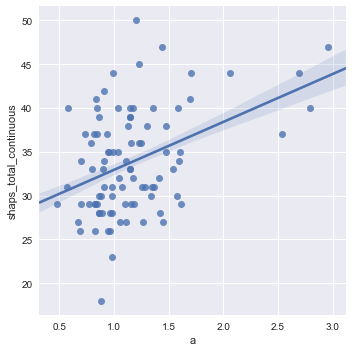

In [14]:
# Does it look like thomas' in depressed_flanker.ipynb if we use just the first session people?
# No it looks like the opposite

just_time_one = tw_merged[tw_merged.ProjectSpecificID.isin(old_ppl.subj_idx.unique())]
executive_shaps = sns.lmplot(y = 'shaps_total_continuous', x = 'a', data = just_time_one[just_time_one['feasibility'] == 'MDD'], ci=68)

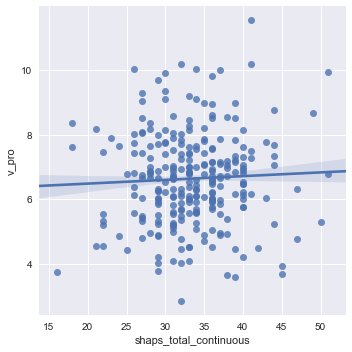

In [22]:
# And v_pro?

prepotent_shaps = sns.lmplot(y = 'v_pro', x = 'shaps_total_continuous', data = tw_merged[tw_merged['feasibility'] == 'MDD'], ci=68)